In [2]:
%load_ext autoreload
%autoreload 2

# Memory Information and GPU Information



In [3]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.88GB
Used: 544.98MB
Percentage: 6.3%


In [4]:
! nvidia-smi

Thu Jun  3 18:17:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Targets

To create a basic skeleton of the the model, and check Learning Capabilities.

**Parameters**: Less than 10,000  
**Data Augmentations**: None  
**Regularization**: None  
**LR Scheduler**: None  
**No. of Epochs**: 14  


# Imports

In [5]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git dlutils

Cloning into 'dlutils'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import dlutils.plotter as plotter
import dlutils.train as train
import dlutils.test as test

# Data

In [ ]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))

In [11]:
plotter.data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [4]:
 torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

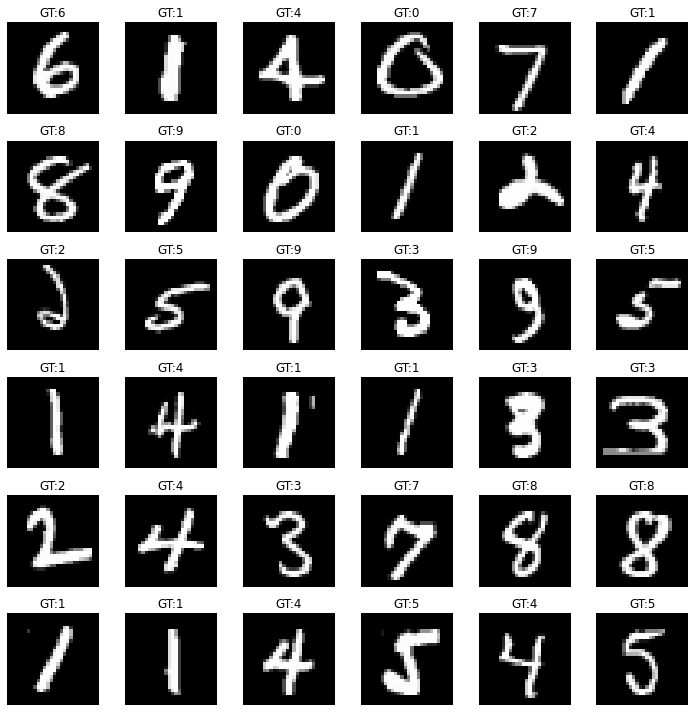

In [10]:
class_list = [0,1,2,3,4,5,6,7,8,9]
plotter.plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            # 28x28x1 -> 26x26x4
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            # 26x26x4 -> 24x24x8
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            # 24x24x8 -> 12x12x8
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.layer2 =  nn.Sequential(
            # 12x12x8 -> 10x10x16
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            # 10x10x16 -> 8x8x16
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            # 8x8x816-> 6x6x16
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            # 6x6x16 -> 4x4x16
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, bias=False)
        )
        
        # 4x4x16 -> 1x1x16
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1)

        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1,10)

        return F.log_softmax(x, dim=1)

In [11]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             576
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,152
              ReLU-9           [-1, 16, 10, 10]               0
      BatchNorm2d-10           [-1, 16, 10, 10]              32
           Conv2d-11             [-1, 16, 8, 8]           2,304
             ReLU-12             [-1, 16, 8, 8]               0
      BatchNorm2d-13             [-1, 16, 8, 8]              32
           Conv2d-14             [-1, 1

# Training

In [17]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = train.Train(model, device, train_loader, optimizer)
tester = test.Test(model, device, test_loader)

for epoch in range(1, 15):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer()
    test_loss, test_acc = tester()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.15231110155582428 batch_id=937: 100%|██████████| 938/938 [00:17<00:00, 52.88it/s]


TRAIN set: Average loss: 0.2009, Train Accuracy: 93.60%
TEST set: Average loss: 0.0504, Test Accuracy: 98.51%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.0497, Train Accuracy: 98.44%
TEST set: Average loss: 0.0342, Test Accuracy: 98.88%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.0387, Train Accuracy: 98.78%
TEST set: Average loss: 0.0338, Test Accuracy: 99.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.0339, Train Accuracy: 98.93%
TEST set: Average loss: 0.0332, Test Accuracy: 98.98%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.0300, Train Accuracy: 99.02%
TEST set: Average loss: 0.0310, Test Accuracy: 99.02%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.0267, Train Accuracy: 99.15%
TEST set: Average loss: 0.0286, Test Accuracy: 99.12%


# Results

In [18]:
print('Train Accuracy:', max(trainer.accuracy))
print('Test Accuracy:', max(tester.accuracy))

Train Accuracy: 99.49833333333333
Test Accuracy: 99.31


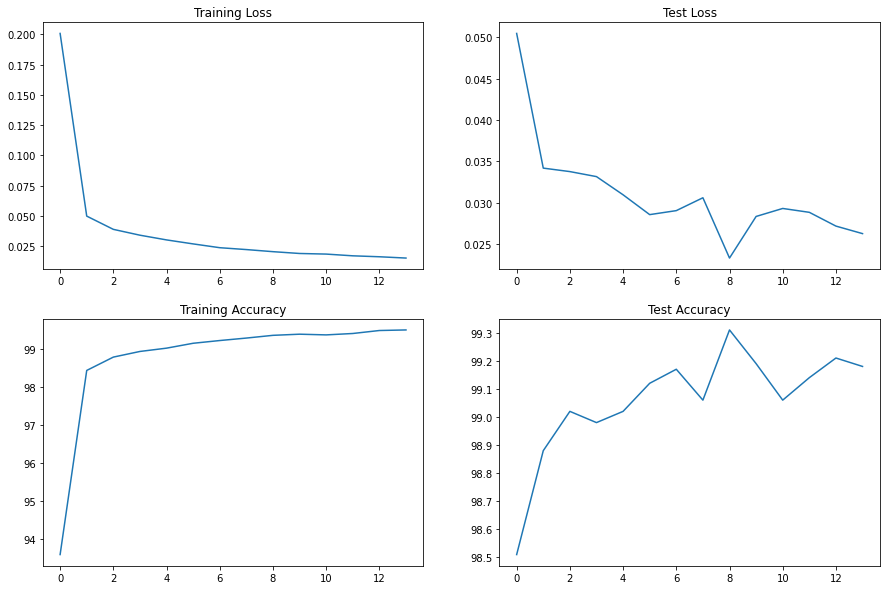

In [19]:
plotter.plot_loss_acc(trainer.loss, trainer.accuracy, tester.loss, tester.accuracy)

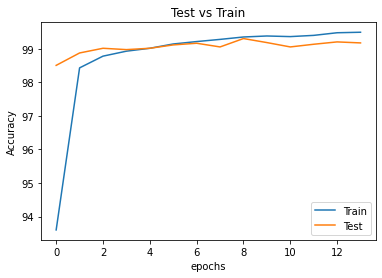

In [20]:
plotter.plot_combined(trainer.accuracy, tester.accuracy,  x_label='epochs', y_label='Accuracy')

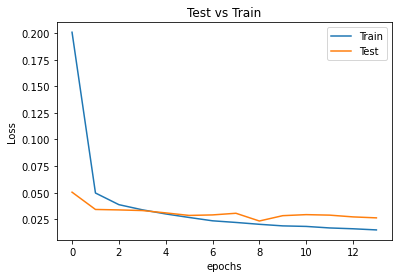

In [21]:
plotter.plot_combined(trainer.loss, tester.loss,  x_label='epochs', y_label='Loss')

In [22]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results = plotter.Results(model, test_loader, device, mean, std, class_list)

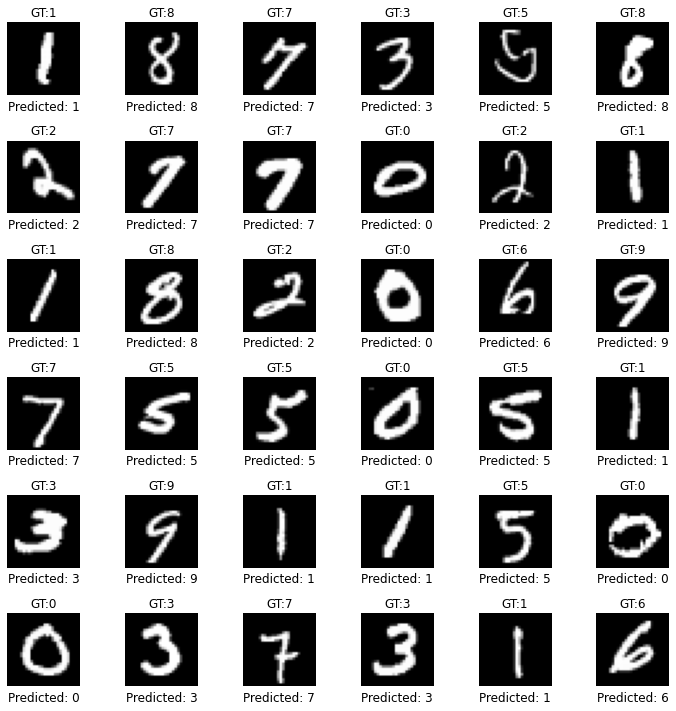

In [23]:
results.plot_batch(6,6)

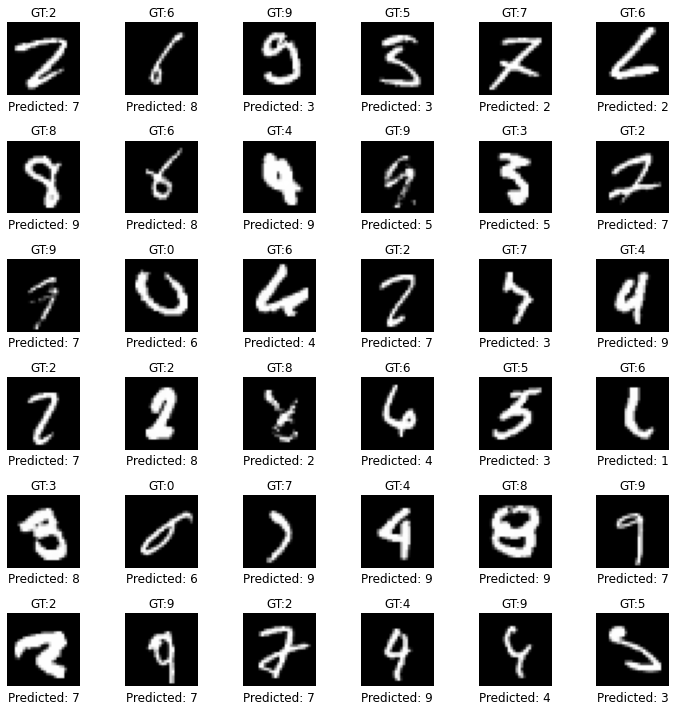

In [24]:
results.plot_incorrect()

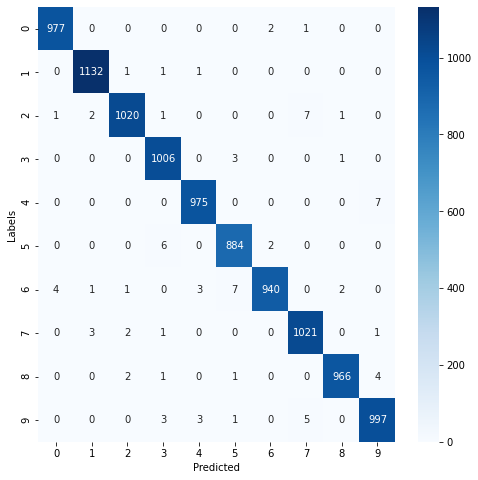

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 6 is 98.12
Accuracy of class 9 is 98.81
Accuracy of class 2 is 98.84
Accuracy of class 5 is 99.10
Accuracy of class 8 is 99.18
Accuracy of class 4 is 99.29
Accuracy of class 7 is 99.32
Accuracy of class 3 is 99.60
Accuracy of class 0 is 99.69
Accuracy of class 1 is 99.74


In [25]:
results.class_accuracy()

# Model Architecture

In [7]:
!pip3 install hiddenlayer

In [ ]:
import hiddenlayer as hl
model = Net().to('cuda')
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_1", "png")

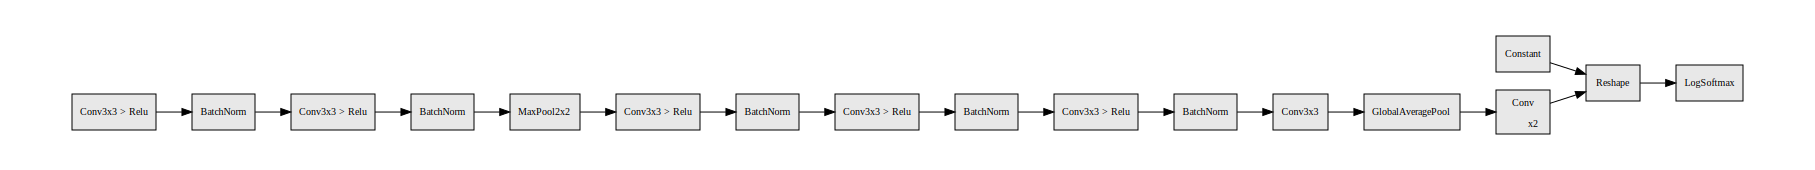

In [13]:
network_graph

# Acheviements

**Total Parameters Used**: 9,714  
**Train Accuracy**: 99.5  
**Test Accuracy**: **99.31**  
**Consistent From**: Not Consistent  
**Data Augmentation**: None


## Analysis

The model is learning as we see that the training accuracy is going to 99.5, which is a good indicator initially, to continue on the skeleton of the model, and work on it to improve the Test Accuracy, as we see there is clearly Over fitting happening. 